In [19]:
from matplotlib import pyplot as plt
import numpy as np
import re

# Select all files to load via regex
regex = ".*"

# Files to load. t = num_timesteps, l = lut_depth, s = samples, w = reward weights
files = [
    "lut_t=2_l=2_w=11_noise=0.0",
    "lut_t=2_l=2_w=11_noise=0.1",
    "lut_t=2_l=2_w=11_noise=0.2",
    "lut_t=2_l=2_w=11_noise=0.3",
    "lut_t=2_l=2_w=11_noise=0.4",
    "lut_t=2_l=2_w=11_noise=0.5",
    "lut_t=2_l=2_w=11_noise=0.6",
    "lut_t=2_l=2_w=11_noise=0.7",
    "lut_t=2_l=2_w=11_noise=0.8",
    "lut_t=2_l=2_w=11_noise=0.9",
    "lut_t=2_l=2_w=11_noise=1.0",
    "lut_t=2_l=2_w=11_noise=1.1",
    "lut_t=2_l=2_w=11_noise=1.2",
    "lut_t=2_l=2_w=11_noise=1.3",
    "lut_t=2_l=2_w=11_noise=1.4",
    "lut_t=2_l=2_w=11_noise=1.5",
    "lut_t=2_l=2_w=11_noise=1.6",
    "lut_t=2_l=2_w=11_noise=1.7",
    "lut_t=2_l=2_w=11_noise=1.8",
    "lut_t=2_l=2_w=11_noise=1.9",
    "lut_t=2_l=2_w=11_noise=inf",
]

fidelities_each = []
loaded_files = []
for file in files:
    if not re.match(regex, file):
        continue

    data = np.load(f"{file}.npz")
    fidelities_each.append(data)
    loaded_files.append(file)

baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]

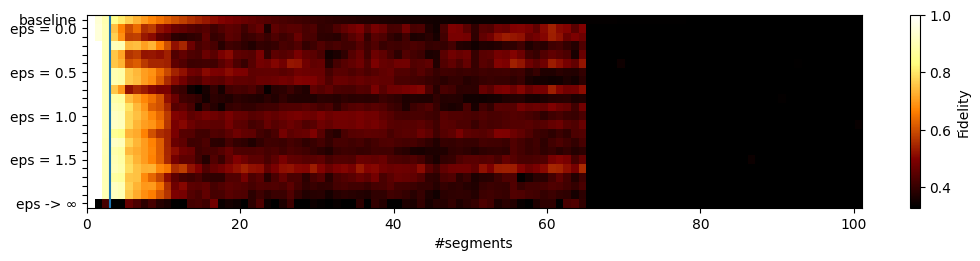

In [20]:
# Read fidelities into matrix and plot 2D graph
from matplotlib.colors import Colormap


label_each = []
first_value = None
for value in fidelities_each[0].values():
    first_value = value
    break
fidelities_mat = np.zeros((len(fidelities_each), len(first_value)))

fig, ax = plt.subplots(1,1, figsize=(12.5,2.5))
for i, (filename, fidelities) in enumerate(zip(loaded_files, fidelities_each)):
    color = (
        "lightgrey" if "grape" in filename else
        "tab:blue"  if "lut" in filename else
        "tab:orange" # rnn
    )

    keyword = (
        "fidelities_grape" if "grape" in filename else
        "fidelities_lut"  if "lut" in filename else
        "fidelities_rnn" # rnn
    )

    F = fidelities[keyword]

    # extract variables from filename
    protocol = re.search(r'^(grape|lut|rnn)', filename).group(1)
    t = int(re.search(r't=(\d+)', filename).group(1))
    w = re.search(r'w=(\d+)', filename).group(1)
    noise = float(re.search(r'noise=([\d.]+|inf)', filename).group(1))

    if protocol == "lut":
        l = int(re.search(r'l=(\d+)', filename).group(1))
        #label = f"{protocol}, t={t}, w={w}, noise={noise}"
        if noise == float("inf"):
            label = "eps -> ∞"
        elif int(noise*100) % 50 == 0:
            label = f"eps = {noise:.1f}"
        else:
            label = ""
    else:
        pass#label = f"{protocol}, t={t}, w={w}, noise={noise}"

    fidelities_mat[i,:] = F
    label_each.append(label)

# Add baseline fidelities as first row
fidelities_mat = np.vstack([baseline_fidelities, fidelities_mat])
label_each = ["baseline"] + label_each

im = ax.imshow(
    fidelities_mat,
    aspect="auto",
    cmap="afmhot",
    vmin=baseline_fidelities[-1], # for better contrast in colormap
    vmax=1.0,
    extent=[0, fidelities_mat.shape[1], fidelities_mat.shape[0], 0],
    interpolation="none",
)
fig.colorbar(im, ax=ax, label="Fidelity")

#ax.set_xlim(0, 10)
ax.set_xlabel("#segments")
ax.set_yticks(np.arange(len(label_each))+0.5)
ax.set_yticklabels(label_each)
ax.axvline(x=3)
fig.savefig("fidelity_comparison", bbox_inches="tight")

[0.39753912 0.38695071 0.38906418 0.39740742 0.40492524 0.39624393
 0.39221271 0.3844624  0.36868691 0.39071311 0.40341146 0.40449854
 0.40390443 0.38523192 0.37954992 0.41124012 0.43566557 0.39351933
 0.39189545 0.38016432 0.31784191]


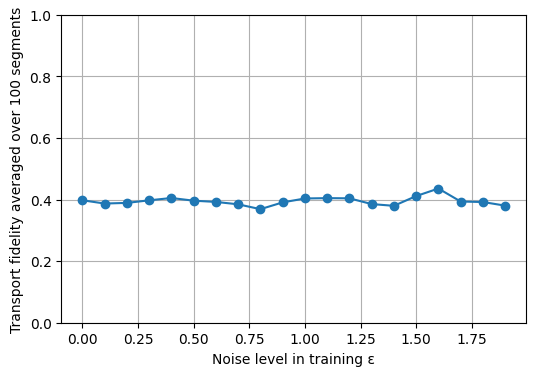

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
mean_fid = fidelities_mat[1:,:100].mean(axis=1)
print(mean_fid)
noise = [float(re.search(r'noise=([\d.]+|inf)', filename).group(1)) for filename in loaded_files]
ax.plot(noise, mean_fid, marker='o')
ax.set_xlabel("Noise level in training ε")
ax.set_ylabel("Transport fidelity averaged over 100 segments")
ax.set_ylim(0,1)
ax.grid()

fig.savefig("mean_fidelity_vs_noise.png", bbox_inches="tight")